In [1]:
import os, re, glob, json, ast, requests
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
pd.set_option('display.max_columns', 20)
from utils import *

# 1. Make subsets

## Import data

In [2]:
tests = pd.read_table('datasets/tests_annotated.tsv')
tests_exploded = pd.read_table('datasets/tests_exploded_annotated.tsv')

moad = pd.read_table('datasets/moad.tsv')
pdbbind = pd.read_table('datasets/pdbbind_train.tsv')

for df in [tests, tests_exploded, moad, pdbbind]:
    df['ligand'] = df['ligand'].map(ast.literal_eval).map(tuple)
tests['ligand_types'] = tests['ligand_types'].map(ast.literal_eval).map(tuple)
tests['ligand_types_unique'] = tests['ligand_types_unique'].map(ast.literal_eval).map(tuple)

In [3]:
# Ligands tanimoto distances
ligands_tanimoto = pd.read_csv('similarity_scores/tanimoto_distances.csv')
ligands_tanimoto = ligands_tanimoto.set_index('test_uid')
ligands_tanimoto_df = ligands_tanimoto.reset_index().melt(id_vars=ligands_tanimoto.index.names, var_name="train_uid", value_name="td")
ligands_tanimoto_df['similarity'] = 1 - ligands_tanimoto_df['td']
ligands_tanimoto_test = ligands_tanimoto_df.sort_values(by='similarity', ascending=False).drop_duplicates('test_uid')

In [4]:
# Protein pocket scores
pocket_scores = pd.read_table('similarity_scores/pocket_scores.tsv', index_col=0)
pocket_scores = pocket_scores.fillna(0)
test_pocket_scores = pd.read_table('similarity_scores/test_pocket_scores.tsv')

In [5]:
### Load tools predictions ###

# all predictions
tools_predictions = {}
for tool_dir in glob.glob(f'predictions_full_raw/*'):
    tool = tool_dir.split('/')[-1]
    predictions = {}
    for file in glob.glob(f"{tool_dir}/*.json"):
        with open(file) as f:
            predictions.update(json.load(f))
    tools_predictions[tool] = predictions

# rmsd only    
tools_predictions_rmsd = {outer_k: {inner_k.replace('_mol0', ''):(inner_v['symm_rmsd'], all(inner_v['posebusters_filters'][:5] + inner_v['posebusters_filters'][12:])) 
                                    for inner_k, inner_v in outer_v.items()} 
                          for outer_k, outer_v in tools_predictions.items()}

tools_predictions_rmsd = pd.DataFrame(tools_predictions_rmsd)
for i in tools_predictions_rmsd.columns:
    tools_predictions_rmsd[i] = tools_predictions_rmsd[i].apply(lambda x: x if pd.isna(x) == False else (666, False) )
tools_predictions_rmsd = tools_predictions_rmsd.loc[tests.uid, :]

tools_predictions_rmsd = tools_predictions_rmsd.loc[:, ['matcha_fromTrue_fast_40', 'diffdock', 'unimol_p2rank', 'gnina_ligand_box', 
                                                                         'vina_ligand_box', 'smina_ligand_box', 'af3', 'chai', 'neuralplexer',
                                                                         'FD', 'boltz_pocket_10A']]
tools_predictions_rmsd

matcha_fromTrue_fast_40                     diffdock  \
6k2n          (11.037799594570826, False)  (22.817555946554254, False)   
6miv          (1.6401742919828899, False)    (34.9112448498111, False)   
6ftf           (0.6496803003608499, True)  (0.5084932640553759, False)   
6e6j           (1.0553402657243343, True)   (1.3259212632883774, True)   
6dz3           (0.8627920780500382, True)  (1.7179369982312278, False)   
...                                   ...                          ...   
1lri_1_CLR_0   (3.903691177792958, False)   (2.457722319786897, False)   
2zux_1_RAM_3  (3.9254846825488303, False)   (32.11441593776942, False)   
4mae_1_PQQ_1   (3.415843468789351, False)  (3.6923889542797816, False)   
6dam_1_PQQ_0   (5.513540242953262, False)  (27.738144420436807, False)   
6fkw_1_PQQ_1  (2.6604692887778634, False)   (4.068904406788407, False)   

                            unimol_p2rank             gnina_ligand_box  \
6k2n           (16.44303879054764, False)  (10.363205724782977, False)   
6miv                         (666, False)  (23.838476166111732, False)   
6ftf          (0.23658390271411456, True)   (0.3903886817441581, True)   
6e6j                         (666, False)                 (666, False)   
6dz3           (4.461894814046727, False)                 (666, False)   
...                                   ...                          ...   
1lri_1_CLR_0  (0.5713123142018784, False)  (1.1008648951522177, False)   
2zux_1_RAM_3  (24.576900138873302, False)   (3.269043386982742, False)   
4mae_1_PQQ_1   (4.439175097492703, False)  (12.659984573132503, False)   
6dam_1_PQQ_0  (0.9881715104018675, False)  (13.210204142475867, False)   
6fkw_1_PQQ_1  (1.2901080462777799, False)  (13.969379496189855, False)   

                          vina_ligand_box             smina_ligand_box  \
6k2n          (12.596024082093113, False)  (12.630179104583448, False)   
6miv           (19.91381618295765, False)  (19.938455578234585, False)   
6ftf           (0.3911842875445986, True)   (0.3885738950584748, True)   
6e6j                         (666, False)                 (666, False)   
6dz3                         (666, False)                 (666, False)   
...                                   ...                          ...   
1lri_1_CLR_0  (1.3768226312800054, False)  (1.3512332321391076, False)   
2zux_1_RAM_3   (9.221948156588214, False)   (9.351721311150218, False)   
4mae_1_PQQ_1   (12.86059024743436, False)  (12.833558115841162, False)   
6dam_1_PQQ_0   (8.419836711063041, False)   (9.346309845220956, False)   
6fkw_1_PQQ_1  (12.849830526097675, False)  (14.469932866518183, False)   

                                      af3                         chai  \
6k2n          (10.318817398451282, False)   (9.587320910494546, False)   
6miv          (0.7963646452047396, False)  (0.6174342906366965, False)   
6ftf          (0.14177139622925816, True)  (24.829861075992156, False)   
6e6j           (0.7712501219732429, True)   (0.6896665892117073, True)   
6dz3           (5.718272523635165, False)  (36.565356882875435, False)   
...                                   ...                          ...   
1lri_1_CLR_0                 (666, False)                 (666, False)   
2zux_1_RAM_3                 (666, False)                 (666, False)   
4mae_1_PQQ_1                 (666, False)                 (666, False)   
6dam_1_PQQ_0                 (666, False)                 (666, False)   
6fkw_1_PQQ_1                 (666, False)                 (666, False)   

                             neuralplexer                           FD  \
6k2n           (8.817242064310328, False)  (20.377592023139844, False)   
6miv           (7.753890110491716, False)   (6.494749768726009, False)   
6ftf           (2.875721329650461, False)   (2.948550154347282, False)   
6e6j                         (666, False)   (2.566995139768033, False)   
6dz3                         (666, False)   (38.29734831474794, False)   
...               

## Make splits

In [6]:
dataset_filters = {
    "Timesplit test (332/363)": lambda df: df['dataset'] == 'timesplit_test',
    "Astex (85)":               lambda df: df['dataset'] == 'astex_diverse_set_ids',
    "DockGen (322/330)":        lambda df: df['dataset'].str.contains('dockgen'),
    "PoseBusters (308)":        lambda df: df['dataset'] == 'posebusters2'
}
datasets_tests = [(name, tests[cond(tests)]) for name, cond in dataset_filters.items()]
datasets_tests_exploded = [(name, tests_exploded[cond(tests_exploded)]) for name, cond in dataset_filters.items()]

In [7]:
### Make splits and subset ###

# Complexity
subsets_complexity = {
    "Big ligands ({n})<br><i>Heavy atoms ≥ 30</i>":
        tests[tests['num_atoms'] >= 30],
    "Medium ligands ({n})<br><i>Heavy atoms 12–30</i>":
        tests[(tests['num_atoms'] >= 12) & (tests['num_atoms'] < 30)],
    "Small ligands ({n})<br><i>Heavy atoms < 12</i>":
        tests[tests['num_atoms'] < 12],
    "Flexible ligands ({n})<br><i>rotatable bonds ≥ 11</i>":
        tests[tests['num_rotbonds'] >= 11],
    "Semiflexible ligands ({n})<br><i>1–10 rotatable bonds</i>":
        tests[(tests['num_rotbonds'] > 0) & (tests['num_rotbonds'] < 11)],
    "Rigid ligands ({n})<br><i>No rotatable bonds</i>":
        tests[tests['num_rotbonds'] == 0],}

# Typical
mask_drug_like = (tests_exploded['buried_frac'] >= 0.8) & \
        (tests_exploded['molecular_weight'] <= 500) & (tests_exploded['molecular_weight'] >= 200) & \
        (tests_exploded['num_rotbonds'] < 11) & \
        (tests_exploded['ligand_types_unique_etc'] == 'other')

drug_like_uids = tests_exploded[mask_drug_like]['uid'].to_list()

subsets_typical = { #<br><i>Buried atoms > 0.8, molecular weight 200-500,<br>rotatable bonds < 11, regular ligands</i>
    "Drug-like ligands from the Tests ({n})": tests_exploded[mask_drug_like],
    "Drug-like ligands<br>from PoseBusters ({n})": tests_exploded[mask_drug_like & (tests_exploded['dataset'] == 'posebusters2')]}

# Similarity-based splits

dissimilar_ligands = ligands_tanimoto[ligands_tanimoto.min(axis=1) > 0.7].index
similar_ligands = ligands_tanimoto[ligands_tanimoto.min(axis=1) < 0.2].index
dissimilar_pockets = test_pocket_scores[test_pocket_scores['score'] < 0.6].test.to_list()
similar_pockets = tests[~tests['uid'].isin(dissimilar_pockets)]['uid']

similarity_sets = {
    "Similar pockets<br>Similar ligands<br>({n})": list(set(similar_pockets) & set(similar_ligands)),
    "Similar pockets<br>Dissimilar ligands<br>({n})": list(set(similar_pockets) & set(dissimilar_ligands)),
    "Dissimilar pockets<br>Similar ligands<br>({n})": list(set(dissimilar_pockets) & set(similar_ligands)),
    "Dissimilar pockets<br>Dissimilar ligands<br>({n})": list(set(dissimilar_pockets) & set(dissimilar_ligands)),
    'In train<br>({n})' : list(set(tests[tests['id'].isin(pd.concat([pdbbind, moad])['id'])]['uid']))
}

similarity_sets_pockets = {
    "Drug-like ligands from the Tests<br>({n})": drug_like_uids,
    "Similar pockets<br>({n}/{p})": list(set(similar_pockets) & set(drug_like_uids)),
    "Disimilar pockets<br>({n}/{p})": list(set(dissimilar_pockets) & set(drug_like_uids)),
}

similarity_sets_ligands_parent = list(set(drug_like_uids) & set(similar_pockets))
similarity_sets_ligands = {
    "Drug-like ligands from the Tests<br>and similar pockets<br>({n})": similarity_sets_ligands_parent,
    "Similar ligands<br>({n}/{p})": list(set(similar_ligands) & set(drug_like_uids) & set(similar_pockets)),
    "Disimilar ligands<br>({n}/{p})": list(set(dissimilar_ligands) & set(drug_like_uids) & set(similar_pockets)),
}

# Ligand classes #
classes_dict_labels = {
    'aa': 'Amino acids,<br>peptides',
    'nt': 'Nucleosides,<br>nucleotides',
    'sac': 'Saccharides',
    'cof': 'Cofactors',
    'macro': 'Macrocycles',
    'etc': 'Lipid-like, steroids,<br>organoelement',
    'other': 'Regular',
}

In [8]:
# Complexity
rmsd_ligand_complexity = {
    k.format(n=len(df)): (
        getMetrics(tools_predictions_rmsd, df['uid'].to_list()),
        getStatGroups(tools_predictions_rmsd,df['uid'].to_list())
    )
    for k, df in subsets_complexity.items()
}

# Typical
rmsd_typical = {
    k.format(n=len(df)): (
        getMetrics(tools_predictions_rmsd, df['uid'].to_list()),
        getStatGroups(tools_predictions_rmsd,df['uid'].to_list())
    )
    for k, df in subsets_typical.items()
}

# Similarity
rmsd_similarity = {
    k.format(n=len(ids)): (
        getMetrics(tools_predictions_rmsd, list(ids)),
        getStatGroups(tools_predictions_rmsd,list(ids))
    )
    for k, ids in similarity_sets.items()
}

rmsd_similarity_pockets = {
    k.format(n=len(ids), p=len(drug_like_uids)): (
        getMetrics(tools_predictions_rmsd, list(ids)),
        getStatGroups(tools_predictions_rmsd,list(ids))
    )
    for k, ids in similarity_sets_pockets.items()
}

rmsd_similarity_ligands = {
    k.format(n=len(ids), p=len(similarity_sets_ligands_parent)): (
        getMetrics(tools_predictions_rmsd, list(ids)),
        getStatGroups(tools_predictions_rmsd,list(ids))
    )
    for k, ids in similarity_sets_ligands.items()
}

# Ligand classes
rmsd_ligand_classes = {
    f"{classes_dict_labels[cls]} ({len(uids)})": (
        getMetrics(tools_predictions_rmsd, uids),
        getStatGroups(tools_predictions_rmsd,uids)
    )
    for cls, uids in {
        c: tests_exploded[tests_exploded['ligand_types_unique_etc'] == c]['uid'].to_list()
        for c in classes_dict_labels
    }.items()
}

# Datasets
rmsd_datasets = {}
rmsd_datasets.update({
    name: (
        getMetrics(tools_predictions_rmsd, df['uid'].to_list()),
        getStatGroups(tools_predictions_rmsd,df['uid'].to_list(), all_tools=True)
    )
    for name, df in datasets_tests
})
rmsd_datasets[f"All ({len(tests)})"] = (
    getMetrics(tools_predictions_rmsd, tests['uid'].to_list()),
    getStatGroups(tools_predictions_rmsd,tests['uid'].to_list())
)

/home/marina/miniconda3/envs/pdb/lib/python3.7/site-packages/statsmodels/stats/weightstats.py:790: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std


# 2. Datasets EDA

In [8]:
# --- Step 2: Annotation counting ---
def get_annotation_counts(df):
    return df['ligand_types_unique_etc'].value_counts().sort_index()

# --- Step 3: Compute counts for each dataset ---
all_counts = [(name, get_annotation_counts(df)) for name, df in datasets_tests_exploded]

# --- Step 4: Collect all unique labels and reindex counts ---
all_labels = sorted(set().union(*(counts.index for _, counts in all_counts)))
label_map = {
    'cof': 'Cofactors',
    'aa': 'Amino acids, peptides',
    'nt': 'Nucleotides',
    'sac': 'Saccharides',
    'other': 'Regular',
    'etc' : 'Lipids, steroids, organoelement',
    'macro': 'Macrocycles',
}
color_map = {
    'cof':   '#f9728d',  # darker/more saturated pink
    'aa':    '#fca6d1',  # brighter pink
    'nt':    '#b3ffe9',  # slightly more vibrant cherry-blossom
    'sac':   '#9eddff',  # stronger persian-pink
    'other': '#cfa0f7',  # deeper mauve
    #'me':    '#8f5ce8',  # more saturated tropical-indigo
    'macro': '#b0f56f',  # deeper mauve-2
    'etc':   '#ffaf02',  # stronger lavender-floral
    #'ster':  '#ffbe0b'   # unique, distinguishable purple
}

color_map = {
    'cof':   '#00b8ff',  # darker/more saturated pink
    'aa':    '#4900ff',  # brighter pink
    'nt':    '#ff00c1',  # slightly more vibrant cherry-blossom
    'sac':   '#00fff9',  # stronger persian-pink
    'other': '#9600ff',  # deeper mauve
    #'me':    '#8f5ce8',  # more saturated tropical-indigo
    'macro': '#00ff6a',  # deeper mauve-2
    'etc':   '#ff6a00',  # stronger lavender-floral
    #'ster':  '#ffbe0b'   # unique, distinguishable purple
}

mapped_labels = [label_map.get(lbl, lbl) for lbl in all_labels]
colors = [color_map.get(lbl, '#cccccc') for lbl in all_labels]

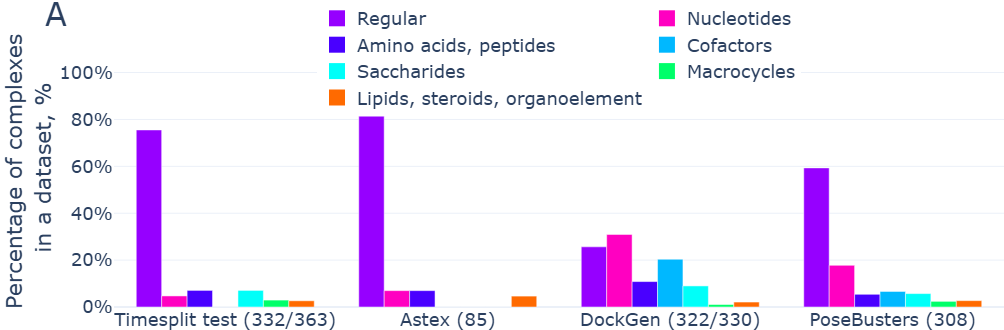

In [39]:
### --- ЗАБОР ПЛОТ --- ###

# Custom plotting order
fsize = 18
ordered_labels = ['other','nt','aa','cof','sac','macro','etc']

mapped_labels = [label_map[lbl] for lbl in ordered_labels]
colors = [color_map[lbl] for lbl in ordered_labels]

# --- Step 5: Build grouped bar chart ---
fig = go.Figure()
dataset_names = [name for name, _ in all_counts]
totals_per_dataset = [counts.sum() for _, counts in all_counts]

for lbl, mapped_lbl, color in zip(ordered_labels, mapped_labels, colors):
    counts_per_dataset = [counts.reindex(ordered_labels, fill_value=0).loc[lbl] for _, counts in all_counts]

    # Skip if all counts are zero
    if all(c == 0 for c in counts_per_dataset):
        continue

    percentages = [c / t * 100 if t > 0 else 0 for c, t in zip(counts_per_dataset, totals_per_dataset)]

    fig.add_trace(go.Bar(
        x=dataset_names,y=percentages,name=mapped_lbl,marker=dict(color=color),#text=[str(c) if c > 0 else "" for c in counts_per_dataset], # empty string if 0
        textposition='outside',hovertemplate="%{x}<br>" + mapped_lbl + ": %{y:.1f}%<br>Count: %{text}<extra></extra>", showlegend=False
    ))
    
    # костыль, чтобы маркеры легенды были побольше
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=20, color=color, symbol='square'), name=mapped_lbl, showlegend=True))
    
fig.add_annotation(x=-0.08, y=1.13, text="A",showarrow=False, xref="paper", yref="paper",font=dict(size=32))    
    
# --- Step 6: Update layout ---
fig.update_layout(
    margin=dict(t=10, b=10, r=0),
    width=1200,
    height=330,
    barmode='group', template='plotly_white', font=dict(size=fsize),  #  xaxis_title="Test datasets", 
    yaxis_title="Percentage of complexes <br>in a dataset, %", yaxis=dict(range=[0, 119], dtick=20, ticksuffix="%"),
    legend=dict(orientation="h", y=1.1, x=0.5, yanchor='top', xanchor="center", font=dict(size=fsize)),
)

fig.update_traces(cliponaxis=False)
fig.show()

In [432]:
fig.write_image("tests_eda_classes.pdf")

In [40]:
fig.write_image("tests_eda_classes.jpg")

In [41]:
custom_colors = {
    'Timesplit test (332/363)': '#ff00c1',  
    'DockGen (322/330)': '#9600ff',        
    'Astex (85)': '#4900ff',            
    'PoseBusters (308)': '#00fff9'
}

In [42]:
sns.set_style("whitegrid")
sns.set_context('notebook', font_scale=1.4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


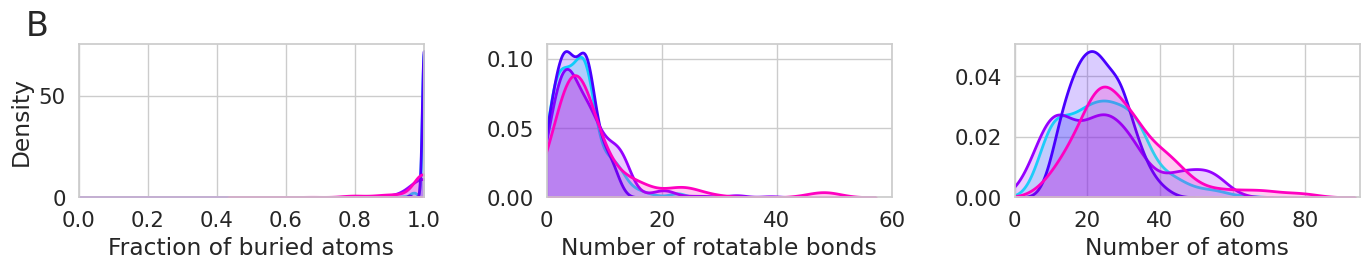

In [43]:
uid_cols = ['buried_frac', 'num_rotbonds', 'num_atoms']
subplot_titles = ["Fraction of buried atoms", "Number of rotatable bonds", "Number of atoms"]

# Combine datasets with a new column 'Dataset'
dfs = []
for label, df_subset in datasets_tests:
    temp = df_subset.copy()
    temp['Dataset'] = label
    dfs.append(temp)
data = pd.concat(dfs)

lims = [(0,1), (0, 60), (0, 95)]

# Create 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 3))
for i, col in enumerate(uid_cols):
    ax = axes[i]
    sns.kdeplot(data=data, x=col, hue='Dataset', ax=ax, common_norm=False, fill=True, linewidth=2, alpha=0.2, palette=custom_colors)
    #sns.histplot(data=data, x=col, hue='Dataset', ax=ax, common_norm=False, linewidth=2, palette=custom_colors, kde=True)
    ax.set_xlim(lims[i])
    ax.set_ylabel('')
    ax.set_xlabel(subplot_titles[i])
    ax.legend().set_visible(False)

#axes[2].set_ylim(0,0.05)    
axes[0].set_ylabel('Density')
axes[0].set_title('B', x=-0.12, size=24)
'''
first_legend = axes[0].get_legend()
axes[0].get_legend().remove()
fig.add_artist(first_legend)
first_legend.set_bbox_to_anchor((0.7, 1))
axes[1].legend().set_visible(False)
axes[2].legend().set_visible(False)
'''
plt.tight_layout()
plt.show()

In [411]:
fig.savefig('tests_eda_physchem.pdf', format='pdf')

In [44]:
fig.savefig('tests_eda_physchem.jpg', format='jpg')

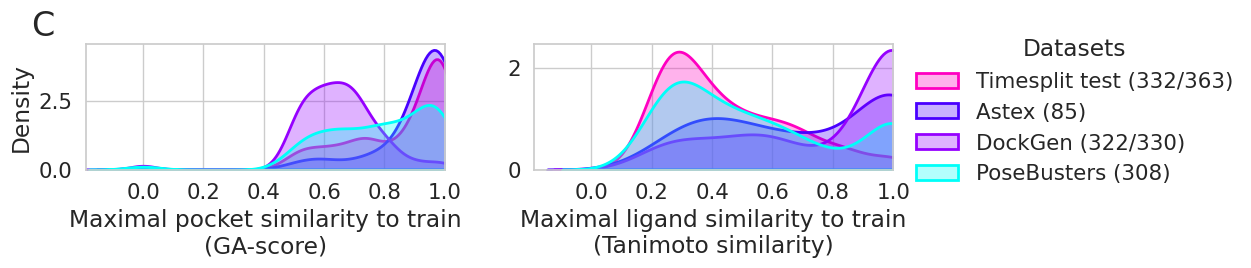

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(14, 3))

for name, dataset in datasets_tests:
    sns.kdeplot(test_pocket_scores[test_pocket_scores['test'].isin(dataset.uid.to_list())]['score'], 
                ax=axes[0], label=name, color=custom_colors[name], common_norm=False, fill=True, linewidth=2, alpha=0.3)
    #sns.histplot(test_pocket_scores[test_pocket_scores['test'].isin(dataset.uid.to_list())][1], 
    #            ax=axes[0], label=name, color=custom_colors[name], common_norm=False, binwidth=0.2, kde=True)
    sns.kdeplot(ligands_tanimoto_test[ligands_tanimoto_test['test_uid'].isin(dataset.uid.to_list())]['similarity'], 
                ax=axes[1], label=name, color=custom_colors[name], common_norm=False, fill=True, linewidth=2, alpha=0.3)
    axes[0].set_xlabel('Maximal pocket similarity to train\n(GA-score)')
    axes[1].set_xlabel('Maximal ligand similarity to train\n(Tanimoto similarity)')
    axes[0].set_xlim(-0.19,1)
    axes[1].set_xlim(-0.19,1)
    axes[1].set_ylabel('')

axes[0].set_title('C', x=-0.12, size=24)
plt.legend(title="Datasets", bbox_to_anchor=(2, 1.2), frameon=False)

for ax in axes:
    ax.set_xticks(np.arange(0, 1.1, 0.2))

plt.tight_layout()
plt.show()

In [413]:
fig.savefig('tests_eda_similarity.pdf', format='pdf')

In [46]:
fig.savefig('tests_eda_similarity.jpg', format='jpg')

# 3. Performance on subsets

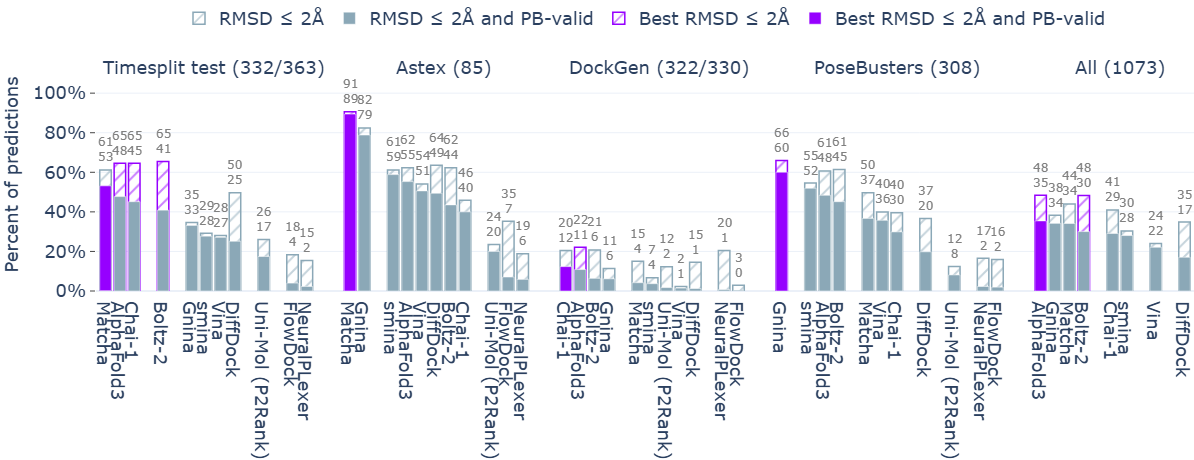

In [9]:
w = 460
plot_grouped_bars(rmsd_datasets, 'rmsd_datasets_extended', w*3, w)

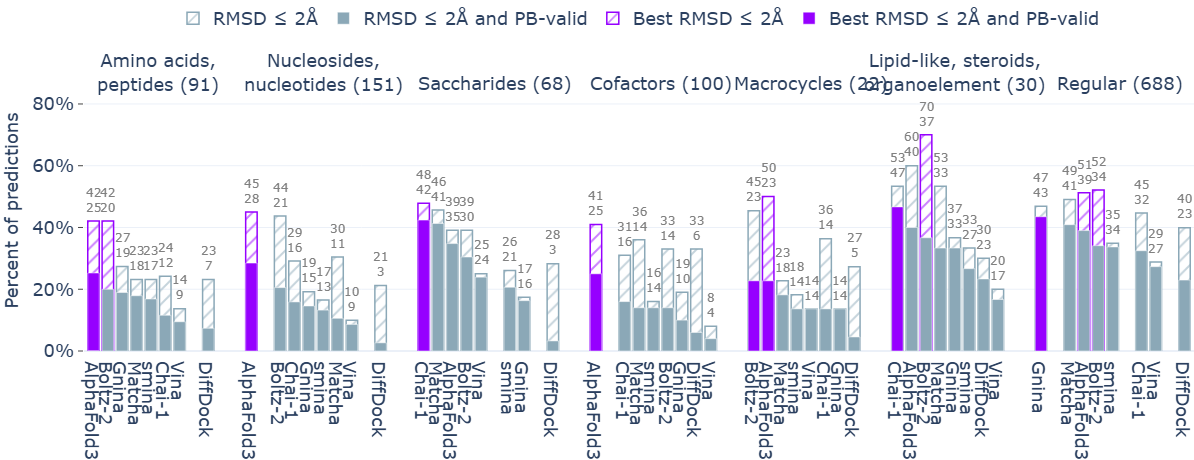

In [10]:
w = 460
plot_grouped_bars(rmsd_ligand_classes, 'rmsd_ligand_classes', w*3, w)

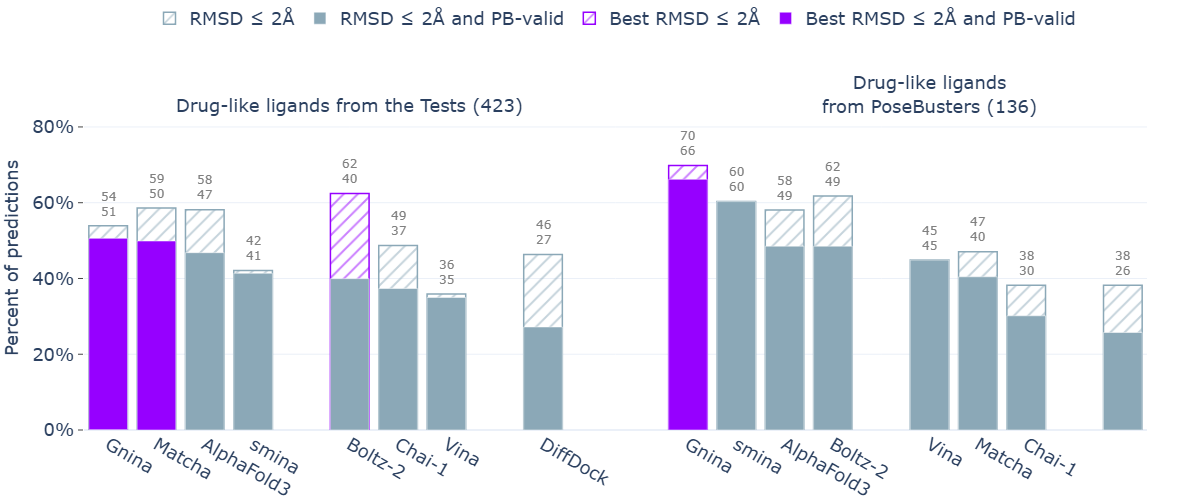

In [11]:
plot_grouped_bars(rmsd_typical, 'rmsd_typical', 800, 500)

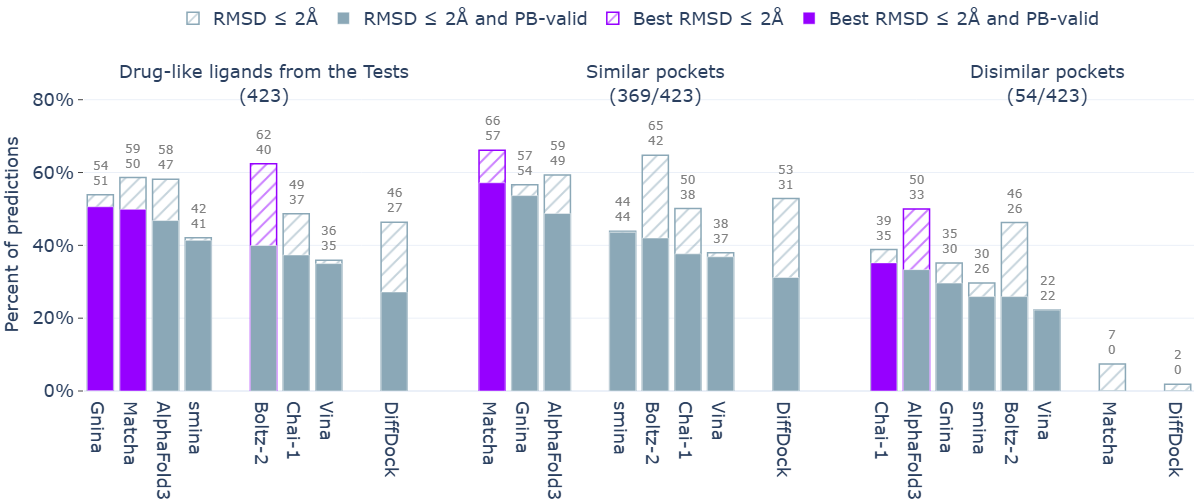

In [12]:
plot_grouped_bars(rmsd_similarity_pockets, 'rmsd_similarity_pockets', 900, 500)

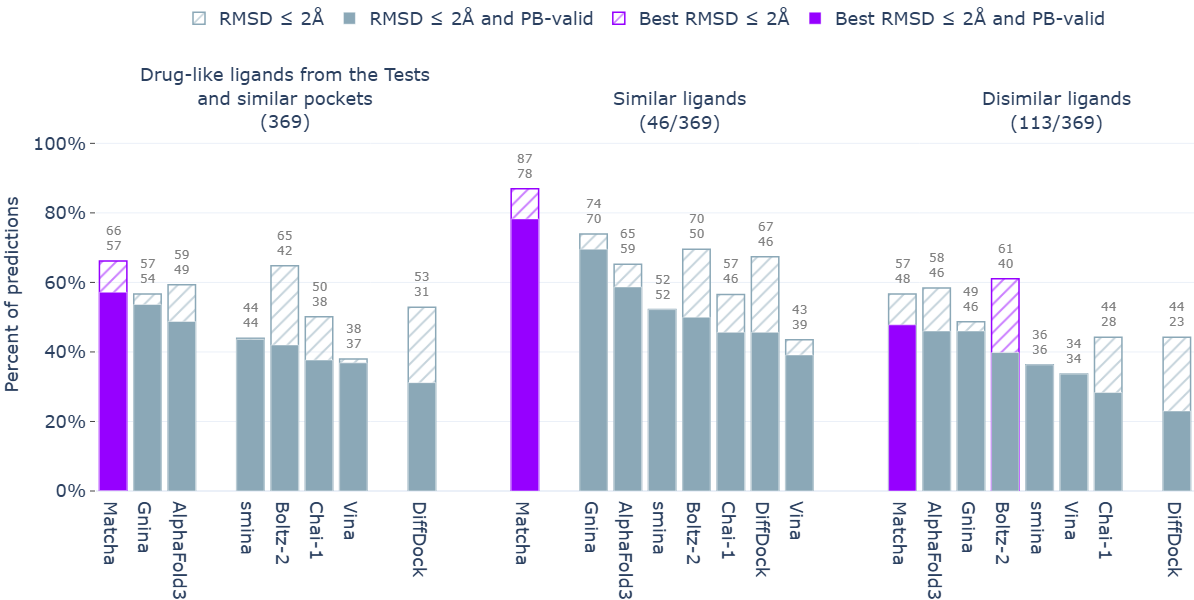

In [14]:
plot_grouped_bars(rmsd_similarity_ligands, 'rmsd_similarity_ligands', 1000, 600)

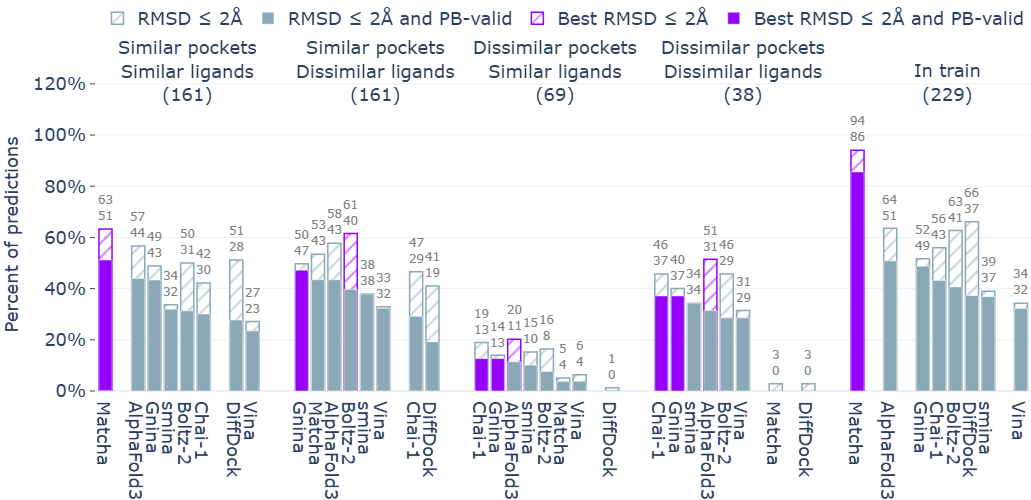

In [15]:
plot_grouped_bars(rmsd_similarity, 'rmsd_similarity', 1200, 500)

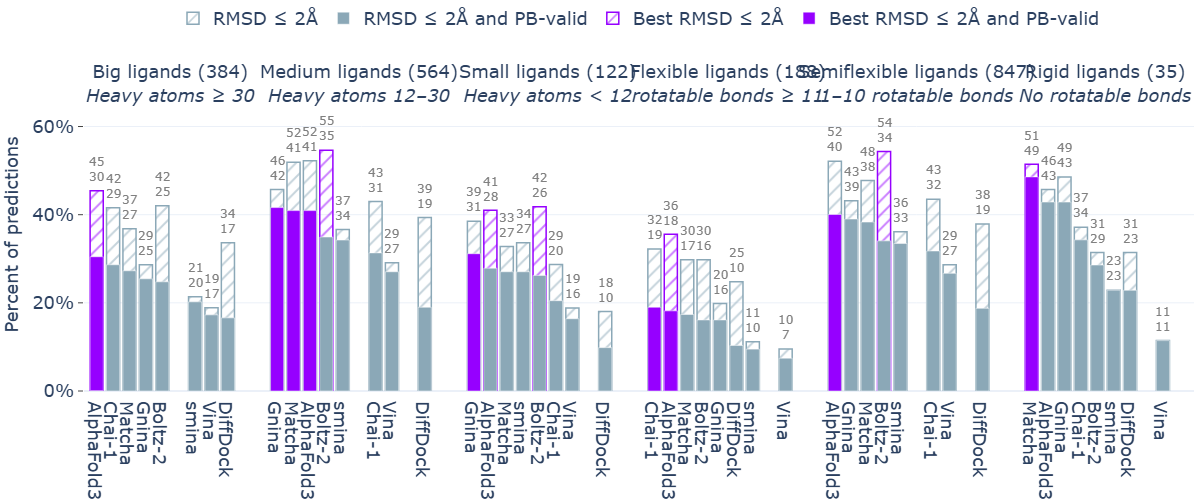

In [16]:
plot_grouped_bars(rmsd_ligand_complexity, 'rmsd_ligand_complexity')